# Fake News Detection with Graph CNN
-------------------------------------------
In this project, the _"User Preference-aware"_ method for detecting fake news, proposed in [1], is implemented. 

Traditional methods for detecting fake news are based on textual content analysis of the piece of news. 

In the above-mentioned work instead, user preferences (personality, sentimentent and stance) are used together with the propagation graph of the news, in addition to the textual content of the news. 

The user's preference are estimated by looking at the historical posts. 

News propagation graph is build on the chain of retweets of a news. 

The result is to model each news as a tree-graph where the root is the news source and the leaves are the users who retweeted the news on which perform a graph classification.  


The model used is a graph convolutional network implemented from scratch following paper in [2]. 

#### References:
 [[1] UPFD paper](https://arxiv.org/abs/2104.12259) : Yingtong Dou, Kai Shu, Congying Xia, Philip S. Yu, Lichao Sun _"User Preference-aware Fake News Detection"_ arXiv:2104.12259 (2021)

 [[2] GCN paper](https://arxiv.org/abs/1609.02907): Thomas N. Kipf, Max Welling _"Semi-Supervised Classification with Graph Convolutional Networks"_ arXiv:1609.02907v4 (2017)

### Setup

In [ ]:
# Install pytorch geometric 
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math 
from torch.nn import Linear
from torch.nn.parameter import Parameter
from torch_geometric.datasets import UPFD
from torch.nn.modules.module import Module
from torch_geometric.transforms import BaseTransform, Compose, NormalizeFeatures
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
seed = 42 
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
import os
PATH = os.path.join(os.getcwd(), "data/UPFD")
NAME    = "gossipcop"
FEATURE = "content"

## Data Exploration 

In [ ]:
train_data= UPFD(root = PATH,name =NAME, feature=FEATURE)
sample_graph = train_data[6]
print(sample_graph)
print("Number of graphs in the train dataset:",len(train_data))
print("Number of node features:",sample_graph.x.size(1))
print("Number of nodes in a sample graph:",sample_graph.x.size(0))
print("Shape of the edge list:",sample_graph.edge_index.shape)

Data(x=[76, 310], edge_index=[2, 75], y=[1])
Number of graphs in the train dataset: 1092
Number of node features: 310
Number of nodes in a sample graph: 76
Shape of the edge list: torch.Size([2, 75])


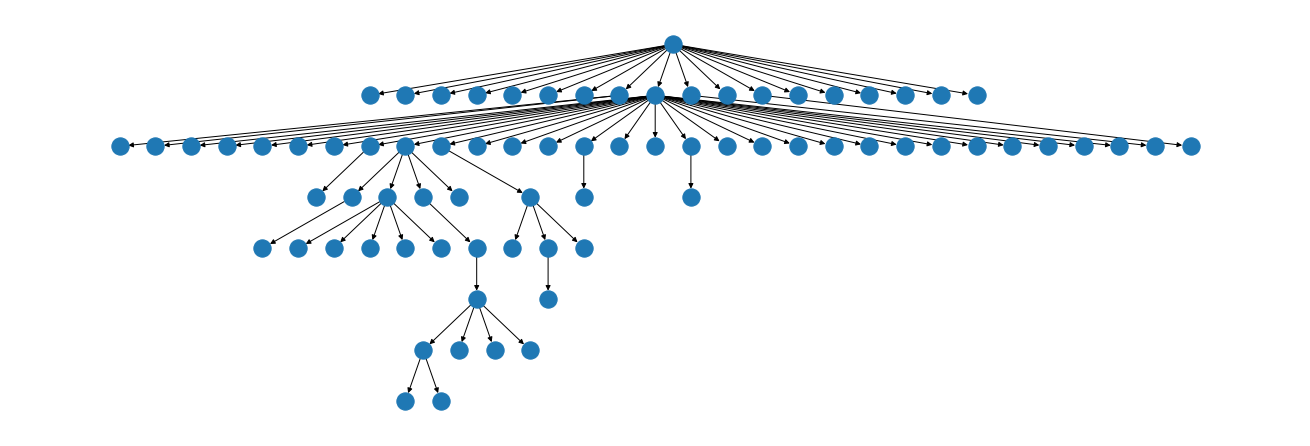

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
plt.figure(figsize=(18,6))
g = to_networkx(sample_graph)
pos = graphviz_layout(g, prog="dot")
nx.draw(g, pos)

The single data point is a tree graph where the root node represents the source news, and leaf nodes represent Twitter users who retweeted the same root news. A user node has an edge to the news node if and only if the user retweeted the root news directly. Two user nodes have an edge if and only if one user retweeted the root news from the other user.

Each node is associated to a 310-dimensional feature vector composed by two parts: 
- the 300-dimensional node feature is composed of Twitter user historical tweets encoded by the word2vec encoder. 
- the 10-dimensional node feature is composed of ten Twitter user profile attributes. 

## Preprocess functions

- extract the **Adjacency Matrix** from the edge_index 
- normalize it according to Thomas N. Kipf, Max Welling (2017)

In [ ]:
class NormalizeLabels(BaseTransform):
    """Cast the labels into float."""
    def __call__(self, data):
        data.y = data.y.type(torch.FloatTensor)
        return data

In [ ]:
class Normalize_Adj(BaseTransform):
    """Add the normalised adiancence matrix to an Data object passed to it as input. 
    The matrix is extracted from the edge list."""
    def __call__(self, data):
        """add the adj attribute to data"""
        data.adj = self.get_normalize_adj(data)
        return data

    def get_normalize_adj(self, data):
        """Return the normalized adjacency matrix extracted from data edge_index.
        Normalization consist in:
        - make the matrix simmetrical 
        - add self loops 
        - Normalizing A such that all rows sum to one"""
        adj_mtx = to_dense_adj(data.edge_index).squeeze()
        adj_mtx_sp = sp.coo_matrix(adj_mtx)

        adj_mtx_sp = (adj_mtx_sp +
         adj_mtx_sp.T.multiply(adj_mtx_sp.T > adj_mtx_sp) - 
         adj_mtx_sp.multiply(adj_mtx_sp.T > adj_mtx_sp) )# make symmetric
          
        adj_mtx_sp += sp.eye(adj_mtx_sp.shape[0]) #add self loops
        adj_mtx_sp = self.normalize(adj_mtx_sp)
        adj_mtx_sp = self.sparse_mx_to_torch_sparse_tensor(adj_mtx_sp)
        return adj_mtx_sp

    def normalize(self, mx):
        """Normalizing A such that all rows sum to one, 
        that is  D^−1 A, where D is the diagonal node degree matrix."""
        rowsum = np.array(mx.sum(1))
        r_inv = np.power(rowsum, -1).flatten()
        r_inv[np.isinf(r_inv)] = 0.
        r_mat_inv = sp.diags(r_inv)
        mx = r_mat_inv.dot(mx)
        return mx

    def sparse_mx_to_torch_sparse_tensor(self, sparse_mx):
        """Convert a scipy sparse matrix to a torch sparse tensor."""
        sparse_mx = sparse_mx.tocoo().astype(np.float32)
        indices = torch.from_numpy(
            np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
        values = torch.from_numpy(sparse_mx.data)
        shape = torch.Size(sparse_mx.shape)
        return torch.sparse.FloatTensor(indices, values, shape)
        

## Data Loading

In [ ]:
train_data = UPFD(root = PATH,name =NAME, feature=FEATURE,
 transform=Compose([NormalizeFeatures(), Normalize_Adj(),NormalizeLabels()])
 )

val_data = UPFD(root = PATH,name =NAME,split="val", feature=FEATURE,
 transform=Compose([NormalizeFeatures(), Normalize_Adj(),NormalizeLabels()])
 )

test_data = UPFD(root = PATH,name =NAME,split="test", feature=FEATURE,
 transform=Compose([NormalizeFeatures(), Normalize_Adj(),NormalizeLabels()])
 )

print("Train Samples: ", len(train_data))
print("Valid Samples: ", len(val_data))
print("Test  Samples: ", len(test_data))

print("Node feature dimension:", train_data.data.x.size(1))

Train Samples:  1092
Valid Samples:  546
Test  Samples:  3826
Node feature dimension: 310


## GCN Layer and Model 

A classic GCN Layer is implemented, it takes as input: 
- A feature $X$ of dimension  $N \times D $ ($N$ number of nodes, $D$ features dimesion)
- the (normalized) adjacency matrix $A$

and produces a node level output $H$ ($N \times F$, where $F$ is the number of output features per node) feature matrix according to 

the rule $H = \sigma(A X W)$, where $W$ is a learnable weight matrix of the layer and $\sigma(.)$ is a non-linear activation function. 

In [ ]:
class GC_Layer(Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = Parameter(torch.FloatTensor(in_dim, out_dim))
        self.bias = Parameter(torch.FloatTensor(out_dim))
        self.reset_parameters()

    def reset_parameters(self):
        std = 1./math.sqrt(self.W.size(1))
        self.W.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input, adj):
        x = input @ self.W
        out = torch.sparse.mm(adj, x)
        out += self.bias
        return out  

The forward pass into the GCN Model is composed by the following steps:

1. The features vector (_news textual embeddings_ + _user features_) is passed through two levels of GCN to learn a node-level embeddings. 

2. A mean pooling operation over all node embeddings is done to get a graph-level features, called _user engagement embedding_.

3. Since the _news textual embedding_ typically contains more explicit signals regarding the news's credibility, it is convenient to concatenate it with _user engagement embedding_. The result is then fed into a two-lawer Multi-layer Perceptron.

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()

        self.gc1 = GC_Layer(in_dim, hid_dim)
        self.gc2 = GC_Layer(hid_dim, hid_dim)

        self.lin0 = Linear(in_dim, hid_dim)
        self.lin1 = Linear(2 * hid_dim, hid_dim)
        self.lin2 = Linear(hid_dim, out_dim)        

        
    def forward(self, x, adj):
        h = F.relu(self.gc1(x, adj))
        h = F.relu(self.gc2(h, adj))
        # max pooling operation 
        h, _ = torch.max(h, dim=0)
        root_x = x[0]
        root_x = F.relu(self.lin0(root_x))
        h = F.relu(self.lin1(torch.cat([root_x,h], dim = -1)))
        out = self.lin2(h)
        return out

In [ ]:
model = GCN(in_dim=train_data.data.x.size(1),
            hid_dim=128,
            out_dim=1
            )

model 

GCN(
  (gc1): GC_Layer()
  (gc2): GC_Layer()
  (lin0): Linear(in_features=310, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=1, bias=True)
)

## Training 

In [ ]:
@torch.no_grad()
def val_loss(val_data):
    """Return the loss evalued on val_data"""
    model.eval()
    loss_val = 0 
    for data in val_data:
        data = data.to(device)       
        adj_mtx_sp = data.adj   
        out = model(data.x, adj_mtx_sp)        
        loss_val += F.binary_cross_entropy_with_logits(out, data.y)

    return loss_val / len(val_data)

In [ ]:
@torch.no_grad()
def accuracy(val_data):
    """Return the accuracy and the 
    vector of predictions evalued on val_data"""
    model.eval()
    loss_val = 0 
    y_pred = []
    total_correct = total_examples = 0
    for data in val_data:
        data = data.to(device)    
        x = data.x 
        y = data.y 
        adj_mtx_sp = data.adj   
        out = model(x,adj_mtx_sp)        

        pred = int(torch.sigmoid(out) > 0.5)
        total_correct += int(pred == data.y)
        total_examples += 1
        y_pred.append(pred)

    return total_correct / total_examples, y_pred 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.001
hidden = 128 
BATCH_SIZE = 156
num_steps = train_data.data.y.size(0) // BATCH_SIZE
START_EPOCH = 0 
EPOCHS = 90

In [ ]:
# Define the model 
model = GCN(in_dim=train_data.data.x.size(1),
            hid_dim=hidden,
            out_dim=1
            ).to(device)
optimizer = optim.Adam(model.parameters(),
                       lr=0.01
                       )


In [ ]:
device

device(type='cpu')

In [ ]:
print(optimizer) 

t0 = time.time()
loss_train_history = []
loss_valid_history = []
acc__valid_history = []


for epoch in range(START_EPOCH, EPOCHS): 
    model.train()
    for step in range(num_steps):     
      loss_train = 0 
      optimizer.zero_grad()
      for data in train_data[BATCH_SIZE*step: BATCH_SIZE*(step + 1)]: 
          data = data.to(device)       
          out = model(data.x, data.adj)
          step_loss = F.binary_cross_entropy_with_logits(out, data.y)
          step_loss /= len(train_data)
          step_loss.backward()
          loss_train += step_loss
      optimizer.step()

    loss_valid = val_loss(val_data)
    acc__valid,y_pred = accuracy(val_data)
    y_true = val_data.data.y.tolist()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # store values 
    loss_train_history.append(loss_train)
    loss_valid_history.append(loss_valid)
    acc__valid_history.append(acc__valid) 

    if (((epoch + 1) % 5) == 0 ):
        print(f"Epoch {epoch+1}, loss_tr {loss_train :.3f}, loss_val {loss_valid :.4f}",
            f"acc_val {acc__valid :.3f}",
            f"tn: {tn} fp:{fp} fn:{fn} tp:{tp}")
print()
print(f"Total time {(time.time() - t0) :.2f} seconds")


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
Epoch 5, loss_tr 0.099, loss_val 0.6938 acc_val 0.485 tn: 265 fp:0 fn:281 tp:0
Epoch 10, loss_tr 0.096, loss_val 0.6936 acc_val 0.485 tn: 265 fp:0 fn:281 tp:0
Epoch 15, loss_tr 0.084, loss_val 0.6187 acc_val 0.516 tn: 265 fp:0 fn:264 tp:17
Epoch 20, loss_tr 0.032, loss_val 0.5187 acc_val 0.767 tn: 261 fp:4 fn:123 tp:158
Epoch 25, loss_tr 0.017, loss_val 0.2481 acc_val 0.921 tn: 258 fp:7 fn:36 tp:245
Epoch 30, loss_tr 0.017, loss_val 0.2397 acc_val 0.923 tn: 258 fp:7 fn:35 tp:246
Epoch 35, loss_tr 0.015, loss_val 0.2213 acc_val 0.932 tn: 258 fp:7 fn:30 tp:251
Epoch 40, loss_tr 0.014, loss_val 0.2138 acc_val 0.934 tn: 258 fp:7 fn:29 tp:252
Epoch 45, loss_tr 0.014, loss_val 0.2118 acc_val 0.934 tn: 258 fp:7 fn:29 tp:252
Epoch 50, loss_tr 0.012, loss_val 0.2036 acc_val 0.938 tn: 258 fp:7 fn:27 tp:254
Epoch 55, loss_tr 0.012, loss_val 0.1901 acc_val 0.943 tn: 258 fp:7 fn:24 

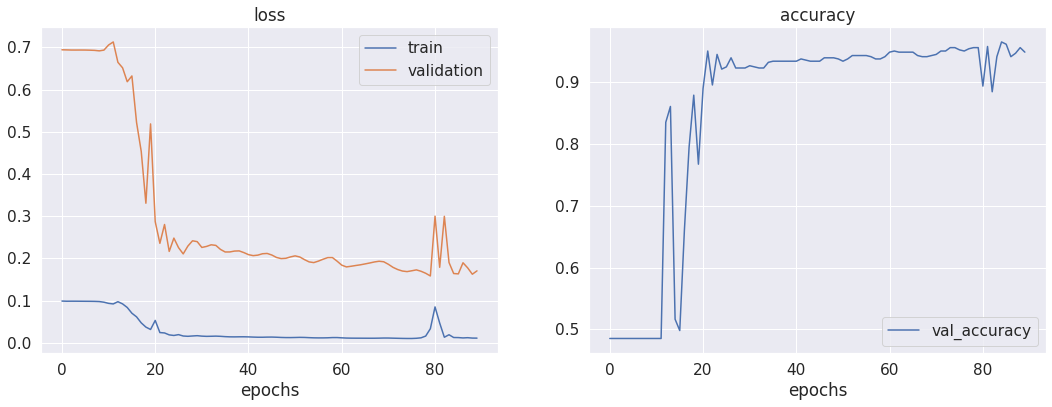

In [ ]:
import matplotlib.pyplot as plt 
sn.set(font_scale=1.4) # for label size

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].plot(loss_train_history, label = 'train') 
axs[0].plot(loss_valid_history,label = 'validation')
axs[0].legend()
axs[0].set_title('loss')
axs[0].set_xlabel('epochs')

axs[1].plot(acc__valid_history,label = 'val_accuracy')
axs[1].set_title('accuracy')
axs[1].set_xlabel('epochs')
axs[1].legend()

In [ ]:
test_acc, y_pred= accuracy(test_data) # 90 epochs + weigth decay = 0
print(f"Accuracy of test dataset: {test_acc : .4f}")

Accuracy of test dataset:  0.9600


In [ ]:
y_true = test_data.data.y.tolist()
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, ['Real', 'Fake'], ['Real', 'Fake'])

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred)) 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1910
           1       0.98      0.94      0.96      1916

    accuracy                           0.96      3826
   macro avg       0.96      0.96      0.96      3826
weighted avg       0.96      0.96      0.96      3826



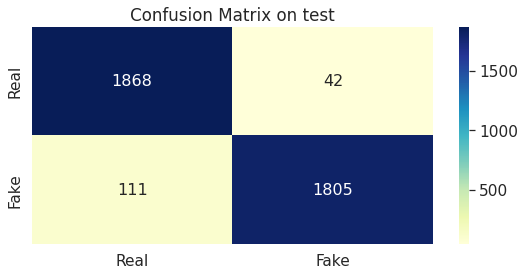

In [ ]:
plt.figure(figsize=(9,4))
plt.title('Confusion Matrix on test')
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d', cmap='YlGnBu') 
plt.show()